# From Jupyter Notebook To Scripts

Geoffrey Hung. Aug 6, 2020.[Here](https://towardsdatascience.com/from-jupyter-notebook-to-sc-582978d3c0c).[Code](https://github.com/G-Hung/model-productization_article).[Source Notebook](https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine)


As advanced beginners, we know quite a lot: EDA, ML concepts, model architectures etc…… We can write a big Jupyter Notebook, click “Restart & Run All” and generate state-of-art results. OK, what next? How can others use/reproduce/scale your results?

In this article, I will show you how I convert a Jupyter Notebook from Kaggle on the Wine dataset to scripts, share some engineering practices that we can adapt easily and bring benefits right away.

For each of them, there is much more to dig in but we will only surface with the basics, show the benefits, and explain the thought process! The goal is to minimize the probability that the engineers roll their eyes when they talk to you.

## Jupyter Notebook
__Jupyter Notebook is nice for exploration and prototype but we cannot stay there forever__. No engineers [Or no one] wants to read your code and rewrite it. Even you are fortunate enough to have engineering resources, it just slows the whole process down🙁

Somehow we need to adapt engineering practices, make it reproducible, automatable, and deployable! The first step is to convert the notebook to scripts and it is the main theme of this article!

## Scripts: ipynb -> .py
Why script? Why can’t we just use the interactive notebook when it is working fine? Let me propose some scenarios to justify why it may be a good idea to use scripts beyond exploration!

1. If you want to run 20 big models in parallel, will you open 20 notebooks?
2. Suppose you are willing to open 20 notebooks, how will you configure the hyperparameters? Go to each notebook and find related cells?
3. Suppose you manually configure 20 notebooks, how will you analyze the results? Go to each notebook?
4. Suppose you can handle 20 notebooks for the first 3 steps, what if you have a great idea but you need to experiment with 200 sets of hyperparameters, are you willing to repeat steps 1–3?
5. Suppose you find a bug in the original notebook and need to rerun everything, are you willing to repeat steps 1–3?

If you answer YES to all, then this article is NOT for you, bye and have a good day 😊

The way I structure the pipeline is to break it down into __etl.py__, __train.py__, and __predict.py__. Each script has its responsibility and tries to be as atomic as possible such that they can be developed by individual teammates as long as the responsibility is clear.
`etl.py`: convert the raw data, do some transformation, create train.csv and test.csv under data folder [train_test_split]
`train.py`: use data in train.csv, export a model to model folder [model.fit(X, y)]
`predict.py`: use data in test.csv and trained model, export the predictions, and evaluate [model.predict(X, y)]

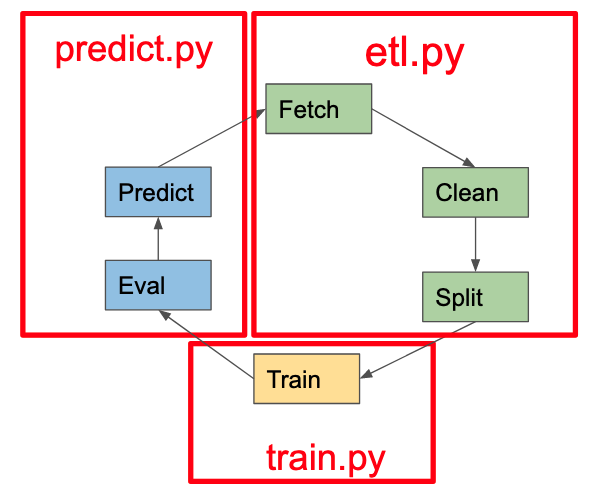

```
# File structure
.
├── README.md
├── __init__.py
├── autoformat.sh
├── data
│   ├── predict.csv
│   ├── test.csv
│   ├── train.csv
│   └── winequality.csv
├── log
│   ├── etl.log
│   ├── predict.log
│   └── train.log
├── model
│   └── model.pkl
├── notebook
│   └── prediction-of-quality-of-wine.ipynb
├── requirement.txt
└── scripts
    ├── config.yml
    ├── etl.py
    ├── predict.py
    ├── test_train.py
    ├── test_utility.py
    ├── train.py
    └── utility.py
```

If I mess up something, I will not try to figure out why [imagine state mutation in Jupyter because you random run the cells], I will just run the script again and see.
```
# Run in command line, as simple as this :)

$ python3 ./scripts/etl.py
$ python3 ./scripts/train.py
$ python3 ./scripts/predict.py
```
Great, we can load and run the scripts in the command line! But as we mentioned in the scenarios above [№2], how can we configure the hyperparameters then ?_?

## Config file as input: click

The principle is to try not to touch the code, I have created another config.yml to contain all the configurations and load them via [click](https://click.palletsprojects.com/en/7.x/). In this way, every new model is just another configuration, this ensures the reproductivity and avoids manually changing the code [and introduce bugs 🙁 ].

```Python
# config.yml example, I only use this to configure the scripts
etl:
  raw_data_file: "data/winequality.csv"
  processed_path: "data"
  test_size: 0.2
  random_state: 42
train:
  processed_train: "data/train.csv" 
  ensemble_model: "RandomForestClassifier"
  model_config: {n_estimators: 300}
  model_path: "model/model.pkl"
predict:
  model_path: "model/model.pkl"
  processed_test: "data/test.csv"
  predicted_file: "data/predict.csv"
  export_result: True
```

Inside the script, I created a utility function to parse the configuration file
```Python
def parse_config(config_file):
    with open(config_file, "rb") as f:
        config = yaml.safe_load(f)
    return config
```
Then we can load the configurations to the scripts in an extensible way!
```Python
@click.command()
@click.argument("config_file", type=str, default="scripts/config.yml")
def etl(config_file):
    config = parse_config(config_file)
    raw_data_file = config["etl"]["raw_data_file"]
    processed_path = Path(config["etl"]["processed_path"])
.......DO SOMETHING.......
```
If we have 20 models with a similar architecture, we can just prepare 20 configurations, that’s it

No print: logging
We can now combine the script and configuration in the command line environment! How can I get the outputs? In the Jupyter world, I will print and see but it means I need to scan through a long long notebook, what if I have many models? Is there any concrete way to collect the outputs in a file?

Let print go, learn [logging!](https://docs.python.org/3/howto/logging.html) Logging module in Python does what its name suggests, do logging in Python. We can define and log the things we are interested in, for example, which stage of the script [for debug], a summary of the metrics [for evaluation], I extracted a piece from model prediction and evaluation as an example

```Python
##################
# Make prediction and evaluate
##################
logger.info(f"-------------------Predict and evaluate-------------------")
y_hat = trained_model.predict(X)
logger.info(f"Classification report: \n {classification_report(y, y_hat)}")
output = pd.DataFrame(y)
output["prediction"] = y_hat
if export_result:
    output.to_csv(predicted_file, index=False)
    logger.info(f"Export prediction to : {predicted_file}")
    
```

This piece of code will generate the log similar to the one below

```
2020-08-06 11:34:24,463 : INFO : utility : Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       273
           1       0.75      0.51      0.61        47

    accuracy                           0.90       320
   macro avg       0.84      0.74      0.78       320
weighted avg       0.90      0.90      0.90       320

2020-08-06 11:34:24,469 : INFO : utility : Export prediction to : ../data/predict.csv
```

Learn more about logging from this article! [Here](https://www.machinelearningplus.com/python/python-logging-guide/)

### Aside:
Logging is great but still if we have 100 experiments, we will get 100 log files 🙁 Even they are concrete, we may not want to read them one by one, is there any better way to evaluate? Below are some potential solutions:
- Yet another script, utilize grep or regex, parse and extract the key information [but what if someone changes the format or spelling!?]
- Yet another tool, checkout [MLFlow](https://mlflow.org/docs/latest/projects.html) or [ModelDB](https://github.com/VertaAI/modeldb)! [Logging is only one of the features of both products]

## Reproducibility matters: Conda env

Yo, things seem good now! I can push to GitHub and my friends/colleagues can clone and run in their computer 😊
Oh wait……..their computer……..what if we are using different versions? It is common because every package has many versions, eg: [sklearn](https://scikit-learn.org/stable/whats_new.html). The APIs / interfaces may change over time [and breaks the code 🙁 ], how can we ensure we are using the same package?
Short answer: Conda env, check out Matt’s article.[Here](https://towardsdatascience.com/a-guide-to-conda-environments-bc6180fc533)
I list out some useful commands below, just enough for our needs

```
# In terminal
# Create the environment
$ conda create — name YOU_CHANGE_THIS python=3.7 -y
# Activate it
$ conda activate YOU_CHANGE_THIS
# Install the needed package
$ pip install –r requirements.txt
# # ## # ## # ## # ## # ## # ##
# # # Do your development # # #
# # ## # ## # ## # ## # ## # ##
# Deactivate and back to normal environment
$ conda deactivate
# This will remove the environment, do it when you finish the project?
$ conda remove –name YOU_CHANGE_THIS –all
```

*in requirements.txt, you should always specify the version! If you don’t specify it, it will try to download the latest one, but your latest maybe not my latest and lose the whole point of using Conda env

```
# this is what I have inside requirements.txt
pytest==5.3.5
pandas==1.0.1
Click==7.0
scikit-learn==0.22.1
black==19.10b0
isort==4.3.21
PyYAML==5.2
```

## Don’t break your previous code: pytest
In the software / ML world, change is the constant, we change something whenever we work. But how can we ensure the new change doesn’t break the existing one [especially those you wrote a few months before]?

Unit tests are here to help 😊 We can write the test cases for each function to ensure they have the expected behavior. Unit tests cannot prove program correctness but they can safeguard the scenarios you listed!

For example, the code below asserts the type and output dimension are as expected. It seems silly and simple but if your load_data function becomes more complex, you will appreciate something safeguard you all the way [especially if you want to change something, don’t ask me how I know]!

```
import numpy as np
import pandas as pd
import pytest

from utility import load_data


def test_load_data():
    X, y, cols = load_data("data/winequality.csv")

    # type check
    assert isinstance(X, np.ndarray)
    assert isinstance(y, pd.core.series.Series)
    assert isinstance(cols, list)

    # shape check
    assert X.shape[0] == y.shape[0], "# row of features = # rows of target"
    assert X.shape[1] >= 1, "# features >= 1"
    assert len(cols) == 12, "data should have 12 cols"
```

To run the unit test, simply run pytest in the terminal and you should see the output like this
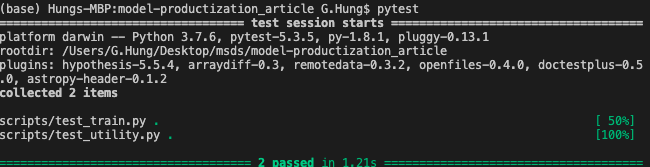

Cool, we can run pytest before we push to GitHub and try to maintain a workable program! But human isn’t reliable, what if we forget to run pytest before push and break the code!? How can we protect ourselves from this situation?

## If possible, don’t rely on human: Continuous Integration

What if the program itself can run the unit tests automatically when we push/create pull request? Then it can stop the merge if it cannot pass the tests! If you heard of continuous integration, this is part of the feature! Popular products in the market are CircleCI / TravisCI / jenkins, but I am lazy, I don’t want to do any extra configuration work if not needed so we will use relatively new GitHub Action for that 😊

```
# This workflow will install Python dependencies, run tests and lint with a variety of Python versions
# For more information see: https://help.github.com/actions/language-and-framework-guides/using-python-with-github-actions

name: Python application

on:
  push:
    branches: [ master ]
  pull_request:
    branches: [ master ]

jobs:
  build:

    runs-on: ubuntu-latest
    strategy:
      matrix:
        python-version: [3.7]

    steps:
    - uses: actions/checkout@v2
    - name: Set up Python ${{ matrix.python-version }}
      uses: actions/setup-python@v2
      with:
        python-version: ${{ matrix.python-version }}
    - name: Install dependencies
      run: |
        python -m pip install --upgrade pip
        pip install pytest
        if [ -f requirements.txt ]; then pip install -r requirements.txt; fi
    - name: Test with pytest
      run: |
        pytest
```

In the past, I think the engineers are so smart, how can they remember the syntax and come up with a script like this [it is simple already] on their own? Don’t think in that way, most people just copy & modify the template as I do [there is a template __called Publish Python package__ under CI workflows in GitHub Actions]

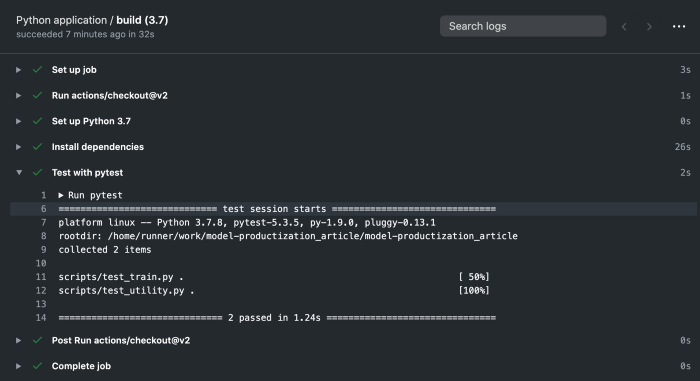

Now you see it! The scripts, package versions, and pytest work together to ensure the package versions are right and the program is workable! They will safeguard us when we develop incrementally, they will say NO if the code breaks the unit tests. If we find a bug, we can include that as another test case to ensure we don’t commit the same mistake twice!
Can you do the same in Jupyter Notebook with the same level of confidence?

### Code Style matters: black, isort
Have you heard of [pep8](https://www.python.org/dev/peps/pep-0008/)? It is the style convention to write Python, there are many (good) points but honestly, please don’t test me on that, my brain cannot remember them all!

I remember in one of my classes, my professor requires us to use [pycodestyle](https://pypi.org/project/pycodestyle/) it is a tool to check the code style, then I got these messages and fix them one by one. For example:

```
$ pycodestyle --first optparse.py
optparse.py:69:11: E401 multiple imports on one line
optparse.py:77:1: E302 expected 2 blank lines, found 1
optparse.py:88:5: E301 expected 1 blank line, found 0
```

I think it is a good tool but kind of incomplete, if you can find my problems, why don’t you just correct that for me and save my time?

```
#/bin/bash
#
# If you get permission error, you can try
# chmod +rx autoformat.sh 

echo 'Running isort'
isort -rc ./scripts

echo 'Running black'
black ./scripts

echo 'Finished auto formatting'
```

```
Simply run this and the script will do the rest!
# If you get permission error, you can try
# chmod +rx autoformat.sh
$ ./autoformat.sh
```

## Conclusions
Things are good for local now! I can push them to GitHub and my friends can clone and run it in their computer

BUT! We know the important (bad) messages usually start with BUT/HOWEVER, eg: job application rejections 🙁

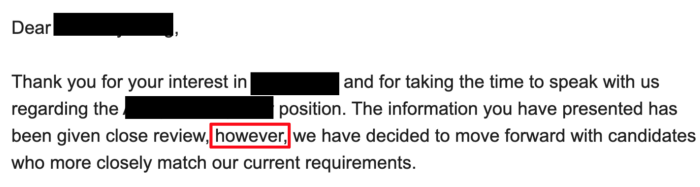

BUT what if we want to productionalize the model ?_?
Q: Firstly, what it means by productionalize?

A: In a narrow sense, it means model consumption, I give you the input, you return me the output [maybe in JSON form], eg: web endpoint / API. We need to have a server [another computer] to host the models and endpoints, I don’t want to use my computer to host it or the whole product will rely on my poor Macbook🙁

I highlighted two words above and they are exactly the challenges

1. How to find another computer to host the models?
Short answer: Either buy a computer OR rent one from cloud provider [eg: AWS, Azure, GCP], then we can claim we know CLOUD COMPUTING 😊
2. What if another computer isn’t MacOS, how can I ensure my code is working there?

Short answer: Docker

To wrap up, we:
```
a. start from a Jupyter Notebook
b. Code conversion [ipynb to .py]
c. Make the scripts configurable [Click]
d. Include logging [logging]
e. Make sure the local environment is the same [Conda env]
f. Include unit test and basic CI [pytest, GitHub Action]
g. Autoformat the script style [black, isort]
```

I hope file tree structure with annotations can show you the code evolution, don’t be scared by many folders because they are developed step-by-step, if you understand the thought process, it is pretty straightforward!

```
.
├── README.md
├── __init__.py
├── .github/workflows         [f]
├── autoformat.sh             [g]
├── data
│   ├── predict.csv           [b]
│   ├── test.csv              [b]
│   ├── train.csv             [b]
│   └── winequality.csv
├── log
│   ├── etl.log               [d]
│   ├── predict.log           [d]
│   └── train.log             [d]
├── model
│   └── model.pkl             [b]
├── notebook
│   └── prediction-of-quality-of-wine.ipynb [a]
├── requirement.txt           [e]
└── scripts
    ├── config.yml            [c]
    ├── etl.py                [b, c]
    ├── predict.py            [b, c]
    ├── test_train.py         [f]
    ├── test_utility.py       [f]
    ├── train.py              [b, c]
    └── utility.py
```

### Something we mentioned but didn’t elaborate:
-> Databricks’s MLFlow / VertaAI’s ModelDB

### Something we can discuss more:
Model deployment in cloud [AWS]
Containerization [Docker]

Now we have built a solid foundation, these scripts are in the form that we can reuse it further! Imagine how can you do this with Jupyter Notebook?

I understand what it feels like when someone said you should try ABC / XYZ but they don’t explain why or how to evolve from scratch, I hope this article can contribute a little bit :)